In [1]:
%matplotlib inline

# importing libraries
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import cufflinks as cf
import seaborn as sns
import pandas as pd
import numpy as np
import quandl
import plotly
import time

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import Markdown, display
from matplotlib.ticker import FuncFormatter
from pandas.core.base import PandasObject
from datetime import datetime

# Setting pandas dataframe display options
pd.set_option("display.max_rows", 20)
pd.set_option('display.width', 800)
pd.set_option('max_colwidth', 800)

# Set plotly offline
init_notebook_mode(connected=True)

# Set matplotlib style
plt.style.use('seaborn')

# Set cufflinks offline
cf.go_offline()

# Defining today's Date
from datetime import date
today = date.today()

import PortfolioAnalyser as pa

In [2]:
# Downloading funds and creating quotes and returns dataframes
Begin = '2000-03-10'
# End = '2017-08-20' # Só activas se quiseres que acabe num dia especifíco 

Tickers = ['SPY.US' , 'RSP.US']

Nomes = ['SPY' , 'RSP']

ETFs = pd.DataFrame()

# Download
for ticker in Tickers:
    url = "https://eodhistoricaldata.com/api/eod/" + str(ticker) + "?api_token=5c982bff80deb2.22427269&period=d."
    ETF = pd.read_csv(url, index_col = 'Date', parse_dates = True)[['Adjusted_close']].iloc[:-1, :]
    ETFs = ETFs.merge(ETF, left_index = True, right_index = True, how='outer')
    
ETFs.columns = Tickers
ETFs = ETFs.fillna(method='ffill')
ETFs = ETFs.replace(to_replace=0, method='ffill')

ETFs = ETFs.loc['2000-07-07':]

fundos = ETFs.copy()

fundos.columns = Nomes
fundos = fundos.dropna()

fundos.index = pd.to_datetime(fundos.index)

In [3]:
#### Normalization to 100 ####
fundos = round((fundos / fundos.iloc[0] * 100), 2)
fundos_2020 = round((fundos['2019-12-31':] / fundos['2019-12-31':].iloc[0] * 100), 2)

Este ano temos ouvido bastante sobre o quanto 5 empresas que representam cerca de 20% da capitalização do S&P 500 têm contribuído para a subida do S&P e que seriam a principal razão para a desconeção entre a recente subida do S&P e a economia "real".

As 5 empresas são, por ordem de capitalização bolsista:

    . Microsoft 5.96%
    . Apple 5.83%
    . Amazon 4.53%
    . Alphabet 3.35%
    . Facebook 2.22%
   
Neste artigo vou tentar não só ver o impacto destas 5 mega empresas como razão para a recente performance do S&P. Destas 5 cotadas apenas a Alphabet apresenta um valor abaixo da cotação de Fevereiro (altura em que o S&P 500 fez máximos).

Não tendo acesso ao S&P 500 sem estas 5 empresas irei usar uma versão do S&P 500 em que os pesos "excessivos" destas acções estão limitados. Neste caso o S&P Equal Weight. O S&P 500 Equal Weight (S&P 500 EW daqui para a frente) é um indíce com uma metedologia de cálculos de pesos diferente do S&P 500 "normal"/Capitalization Weighted (S&P 500 CW daqui para a frente).

O S&P 500 CW é um indíce onde o peso de cada empresa no indíce é representado pela capitalização bolsista da empresa. É assim expectável que uma empresa como a Apple tenha uma maior peso que a maioria das outras empresas, uma vez que a Apple tem uma grande capitalização bolsista, refletindo o tamanho que esta multinacional tem.

Por outro lado num indíce Equal Weight todas as acções têm o mesmo peso aquando do rebalanceamento, que no caso do S&P 500 EW é trimestral. Podemos assim ver grandes empresas como as 5 acima mencionadas a terem pesos semelhantes a outras empresas com muito menor capitalização bolsista, como a Under Armor ou a GAP, ambas com um peso inferior a 0.001% do S&P 500 CW.

Felizmente não só existem estes indíces como temos ETFs que os seguem há bastantes anos:

    . S&P 500 Cap Weighted - SPY
    . S&P 500 Equal Weighted - RSP
    
Os pesos no RSP das 5 empresas acima referidas são:

    . Microsoft 0.22%
    . Apple 0.22%
    . Amazon 0.22%
    . Alphabet 0.2%
    . Facebook 0.19%
    
Não fazendo que estas empresas desapareçam, o RSP acaba por conseguir ir de encontro com a crítica de que o S&P 500 CW é domínado por 5 empresas e podemos assim ver o contributo das mesmas.

Iremos começar por uma simples comparação YTD (2020) do SPY e do RSP.

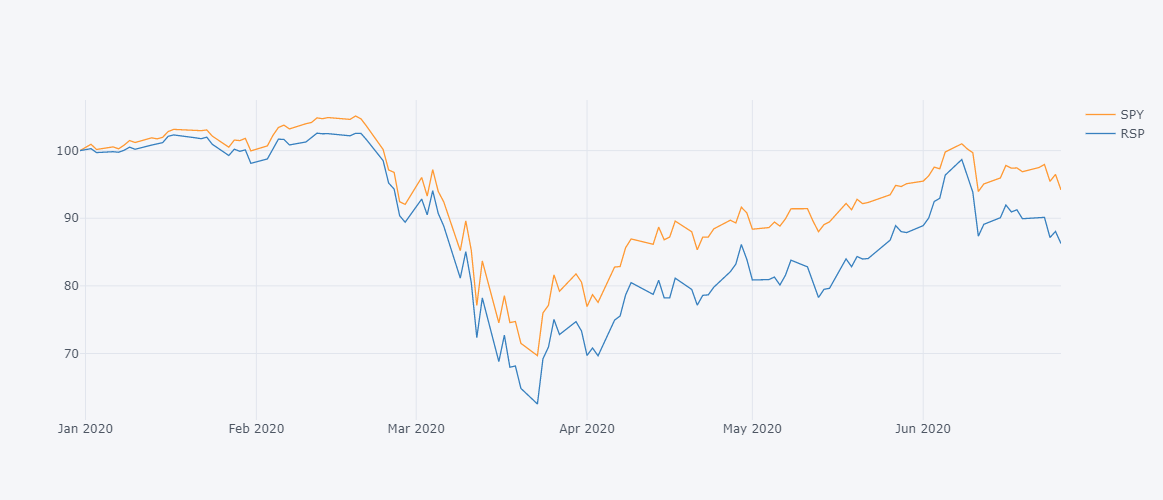

In [4]:
fundos_2020.iplot(dimensions=pa.dimensions)

In [5]:
fundos_2020.to_csv('SPY_vs_RSP_2020.csv')

Podemos ver que a crítica tem algum fundamento, apresentando o S&P uma queda bastante inferior ao RSP. O S&P está com -5.8% YTD vs os -13.7% YTD do RSP. Um diferencial de 8 pontos percentuais em 6 meses é significativo. No início deste mês o diferencial foi, contudo, apenas cerca de 2.5 pontos percentuais. Parece-nos que há uma volatilidade muito grande no que diz respeito ao spread entre ambos os ETFs.

Em baixo podemos ver um gráfico onde podemos ver a overperformance do SPY face ao RSP, ou seja, muito resumidamente quanto o RSP teria que subir para "apanhar" o SPY. Como podemos ver não só o SPY teve sempre melhor performance do que o RSP este ano como, à excepção de uma queda no início de Junho a overperformance tem sido relativamente significativa.

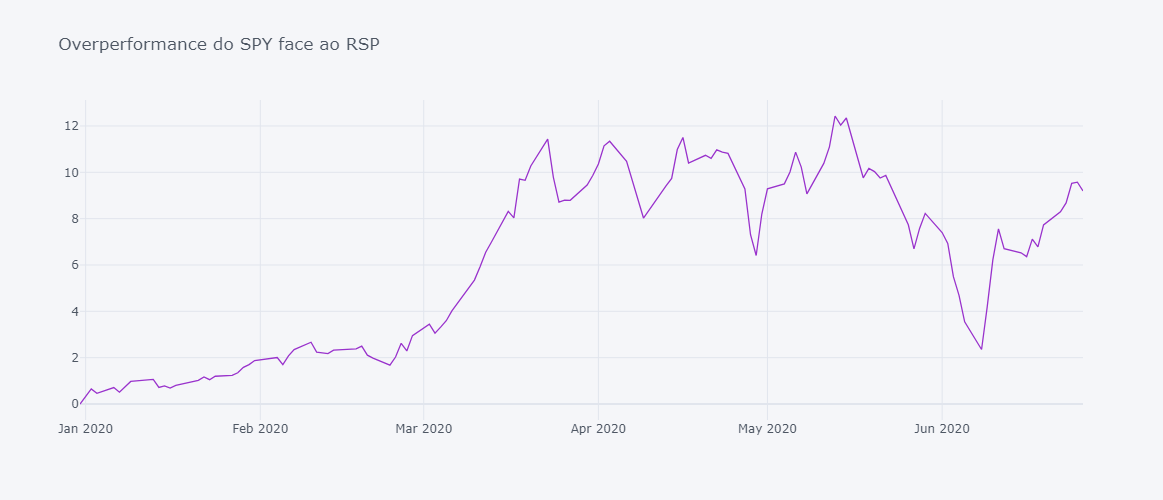

In [6]:
ratio = (((fundos_2020['SPY'] / fundos_2020['RSP']) - 1) * 100)

ratio.iplot(dimensions=pa.dimensions,
            title='Overperformance do SPY face ao RSP',
            color='darkorchid')

In [7]:
pd.DataFrame(ratio).to_csv('SPY_RSP_ratio.csv')

In [13]:
df = pa.compute_performance_table(fundos_2020)[['Return','StdDev','Sharpe','Max DD','MAR']]

In [14]:
heading_properties = [('font-size', '18px')]

cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

df.style.set_table_styles(dfstyle)

,Return,StdDev,Sharpe,Max DD,MAR
SPY,-5.81%,44.87%,-0.26,-33.71%,-0.34
RSP,-13.74%,50.72%,-0.51,-39.04%,-0.67


A verdade é que por coincídência as acções que subiram (ou desceram menos) nesta crise eram já as acções com maior capitalização bolsista do S&P 500 no final de 2019. Embora S&P 500 CW tem beneficiado da boa performance destas 5 mega empresas mas também não é completamente verdade que a maioria das outras empresas não tem subido, tendo no início de Junho 99% das empresas do S&P 500 apresentado uma cotação acima da média dos últimos 50 dias, como podemos ver aqui: https://www.barchart.com/stocks/quotes/$S5FI/interactive-chart.

Para os mais curiosos podem ver no link (aqui) análises mais aprofundadas a :

    . RSP vs SPY (longo prazo e 2008)
    . QQQ vs QQEW (Nasdaq 100 Cap Weighted vs Nasdaq 100 Equal Weighted)

In [9]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Código ON/OFF</button>''', raw=True)

Código ON/OFF